In [1]:
import os
import re

import shutil
import codecs, json 
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc
from scipy import stats
import sklearn as sk
import time
from dypac import Dypac
import nilearn
from nilearn import image, plotting, datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr
import nilearn.plotting as plotting
import csv

import hcp_utils as hcp
import conf

import mne
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import plot_con_helper
import feature_selec_functions
import importlib

ModuleNotFoundError: No module named 'dypac'

## Equalize number of parcels presented in the plot

In [ ]:
#Paths to results 
PATH = conf.RESULTS_DIR

#Create a dict of all the dfs

dfs = ['df_DD_Unil1FixedFisher_02', 'df_F_Unil1FixedFisher_02', 'df_PicVocab_Unil1FixedFisher_02']
df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'beta']]
    df_arranged[dfs[i]] = df

In [ ]:
#For every df, checks if all pair of nodes that exist in both tasks exist in the df. 
#if not, append it to the df with a beta of np.nan.
importlib.reload(plot_con_helper)

df_arranged = plot_con_helper.equalize_parc(df_arranged)

In [ ]:
df_arranged['df_DD_Unil1FixedFisher_02']

## Display only the highest edges in the plot

In [ ]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [ ]:
#Sort df according to beta_abs
for key in df_arranged.keys():
    df_arranged[key] =  df_arranged[key].sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)

In [ ]:
df_arranged['df_DD_Unil1FixedFisher_02']

## Plot results as a circular graph

In [ ]:
df = df_arranged['df_PicVocab_Unil1FixedFisher_02']
node_names = list(df.node1) + list(df.node2)
node_names = list(set(node_names))
con = df.beta.to_numpy() 


In [ ]:
df.head(20)

In [ ]:
#Replace all nans with zeros so the n_line in the plot function works better
df['beta'] = df['beta'].replace(np.nan, 0)

In [ ]:
df

In [ ]:
##Link: https://mne.tools/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html

i_1 = []
i_2 = []
for f in range(len(df)):
    feature = df.iloc[f,:]
    i_1.append(node_names.index(feature['node1']))
    i_2.append(node_names.index(feature['node2']))
indices = (np.array(i_1), np.array(i_2))

lh_names = [name for name in node_names if 'LH' in name]
rh_names = [name for name in node_names if 'RH' in name]
lh_ordered = []
rh_ordered = []
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']
#net_names = net_list
for network in net_names: 
    lh_net_names = [name for name in lh_names if network in name]
    lh_ordered = lh_ordered + lh_net_names

    rh_net_names = [name for name in rh_names if network in name]
    rh_ordered = rh_ordered + rh_net_names
lh_ordered.reverse()
ordered = lh_ordered + rh_ordered

layout = circular_layout(node_names=node_names, node_order=ordered, group_boundaries=[0, len(lh_ordered)])
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
#colors_list = color_list
#colors_list = [(120/255, 18/255, 133/255), (70/255, 130/255, 180/255), (0/255, 118/255, 14/255), (196/255, 57/255, 248/255), (220/255, 248/255, 162/255), (230/255, 146/255, 32/255), (204/255, 60/255, 78/255)]

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in node_names:
    net = name.split('_')[1]
    node_colors.append(color_dict[net])

#colormap_r = ListedColormap(colormap.colors[::-1])

fig = plt.figure(figsize=[10,10], facecolor='white')
plot_connectivity_circle(con, node_names, indices ,fontsize_names=10, n_lines = 50,
                         textcolor='black', facecolor='wheat', node_angles=layout, 
                        node_colors=node_colors, fig=fig, colormap='coolwarm', colorbar=True) 



## Plot several graphs together

In [32]:
import plot_con_helper
import importlib

importlib.reload(plot_con_helper)

#Paths to results 
PATH = conf.RESULTS_DIR

#Plot results of all 3 tasks
#dfs = ['df_DD_l1FixedFisher_02', 'df_F_l1FixedFisher_02', 'df_PicVocab_Unil1FixedFisher_02']

dfs = ['DDisc_AUC_40K', 'DDisc_AUC_200']
#dfs = ['Flanker_AgeAdj_new', 'Flanker_AgeAdj']

df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    #df = df[['node1', 'node2', 'R']] #For reg analysis
    df = df[['node1', 'node2', 'beta', 'rel_edges']] #For models
    df.columns = ['node1', 'node2', 'beta', 'rel_edges']
    df_arranged[dfs[i]] = df
    
#For every df, checks if all pair of nodes that exist in both tasks exist in the df. 
#if not, append it to the df with a beta of np.nan.
df_arranged = plot_con_helper.equalize_parc(df_arranged)
       

In [33]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [34]:
#Sort df according to beta_abs
for key in df_arranged.keys():
    df_arranged[key] =  df_arranged[key].sort_values(by=['beta_abs'], ascending=False,  ignore_index=True)
    df_arranged[key]['beta'] = df_arranged[key]['beta'].replace(np.nan, 0)

In [35]:
#Sort df
#key = "Flanker_AgeAdj"
#df_arranged[key] =  df_arranged[key].sort_values(by=['beta'], ascending=False,  ignore_index=True)
#df_arranged["Flanker_AgeAdj"].head(15)

In [36]:
importlib.reload(plot_con_helper)

node_names_lis = []
con_lis = []
indices_lis = []
ordered_lis = []
node_colors_lis = []
layout_lis = []

for key in df_arranged.keys():
    node_names, con, indices, ordered, node_colors, layout = plot_con_helper.plot_con_helper(df_arranged[key])
    node_names_lis.append(node_names)
    con_lis.append(con)
    indices_lis.append(indices)
    ordered_lis.append(ordered)
    node_colors_lis.append(node_colors)
    layout_lis.append(layout)

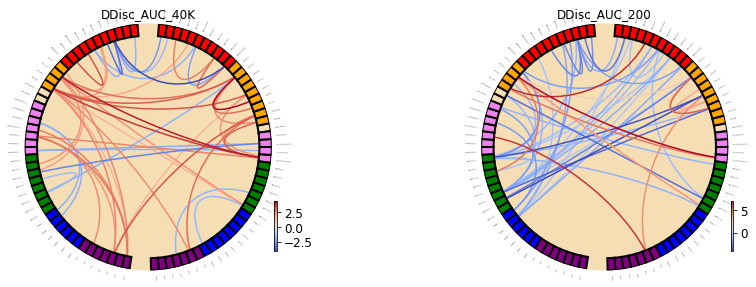

In [37]:
#Plot results of all 3 tasks
##Link: https://mne.tools/stable/auto_examples/connectivity/plot_mne_inverse_label_connectivity.html

fig = plt.figure(num=None, figsize=(15, 10), facecolor='white')
#no_names = [''] * len(label_names)
for ii, df in enumerate(dfs):
    plot_connectivity_circle(con_lis[ii], node_names_lis[ii], indices_lis[ii] ,fontsize_names=0, n_lines=50,
                              textcolor='black', facecolor='wheat', node_angles=layout_lis[ii], 
                             node_colors=node_colors_lis[ii],
                             title=df, padding=0, fontsize_colorbar=12,  colormap="coolwarm",
                             fig=fig, subplot=(len(dfs), len(dfs), ii + 1), show = False)
     
plt.show()

# Find common edges between tasks

In [ ]:
#Paths to results 
PATH = conf.RESULTS_DIR

#Create a dict of all the dfs

dfs = ['DDisc_AUC_40K_l1notFixed', 'Flanker_AgeAdj_l1notFixed']

df_arranged = {}
for i in range(len(dfs)):
    path = PATH + '{}.csv'.format(dfs[i])
    df = pd.read_csv(path)
    df = df[['node1', 'node2', 'beta','rel_edges']]
    df_arranged[dfs[i]] = df

In [ ]:
#Add columns to df: beta_abs, node1_networks, and node2_networks
importlib.reload(plot_con_helper)

for key in df_arranged.keys():
    plot_con_helper.add_col(df_arranged[key])

In [ ]:
df_arranged[dfs[0]]

In [ ]:
#Compare specific networks
res = plot_con_helper.compare_edges(df_arranged, key1 = dfs[0], key2 = dfs[1])

res

In [ ]:
len(res)

In [ ]:
#Compare common network edges (e.g. 7 networks)
importlib.reload(plot_con_helper)

df_common = plot_con_helper.find_common_netEdges(df_arranged)

df_common.head(60)

In [ ]:
g=df_common[(df_common["Beta(df_DD_02)"]!="Empty")&(df_common["Beta(df_F_02)"]!="Empty")]
g

In [ ]:
union = pd.concat([df_arranged[key1], df_arranged[key2]])

In [ ]:
union

## Plot results on a brain

In [22]:
#path to parcellation labels 
path_label = '/mnt/c/Users/liz/Contacts/Desktop/ValuePercept/Parcellations/Parcellations/HCP/fslr32k/cifti/Schaefer2018_100Parcels_7Networks_order_info.txt'

with open(path_label, 'r') as f:
    lines = f.readlines()
    
#lines

In [23]:
#list of parcels
list_parcel = []
for i in range(0, len(lines), 2): #only even rows
    list_parcel.append(lines[i][10:-1])
#len(list_parcel)
#list_parcel

In [24]:
#coordinates for the schaefer parcellation
schaefer = nilearn.datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7).maps
coordinates = plotting.find_parcellation_cut_coords(labels_img=schaefer)

In [25]:
#Paths to results 
PATH = conf.RESULTS_DIR

df_name = 'DDisc_AUC_200'

path = PATH + '{}.csv'.format(df_name)
df = pd.read_csv(path)
#df = df[['node1', 'node2', 'R']] #For reg analysis
df = df[['node1', 'node2', 'beta', 'rel_edges']] #For models
df.columns = ['node1', 'node2', 'beta', 'rel_edges']


In [26]:
#standardized the betas
from sklearn import preprocessing
df["beta_scaled"] = preprocessing.scale(df["beta"])

In [27]:
df.head(10)

,node1,node2,beta,rel_edges,beta_scaled
0,LH_Vis_3,LH_DorsAttn_Post_3,-0.0,"(2, 17)",0.022012
1,LH_Vis_5,LH_DorsAttn_Post_3,-0.0,"(4, 17)",0.022012
2,LH_Vis_5,RH_Vis_4,-0.0,"(4, 53)",0.022012
3,LH_Vis_7,LH_Limbic_TempPole_1,-0.0,"(6, 31)",0.022012
4,LH_Vis_7,LH_Default_PFC_5,-0.0,"(6, 45)",0.022012
5,LH_Vis_7,RH_Limbic_TempPole_1,-0.0,"(6, 79)",0.022012
6,LH_Vis_7,RH_Default_PFCdPFCm_2,-0.0,"(6, 96)",0.022012
7,LH_Vis_7,RH_Default_PFCdPFCm_3,-0.0,"(6, 97)",0.022012
8,LH_Vis_7,RH_Default_pCunPCC_2,-0.0,"(6, 99)",0.022012
9,LH_Vis_8,LH_DorsAttn_Post_3,-0.0,"(7, 17)",0.022012


In [28]:
#Convert the model results into a matrix
rel_features_list = df["rel_edges"].tolist() #relevant edges from the model results

#Convert the list of strings to be a list of tuples
rel_features_tuples = []

for item in rel_features_list:
    rel_features_tuples.append(eval(item))
    

In [29]:
relevant_coefs = df["beta_scaled"]

#Initialize an empty matrix (the size of the nodes number)
num_nodes = 100

relF_mat = np.zeros((num_nodes, num_nodes))
#relF_mat

#For each edge that is one of the relevant edges of the model -> display its coef (also for the reverse edge because the matrix is symetric)
for i, tup in enumerate(rel_features_tuples):
    relF_mat[tup] = relevant_coefs[i]
    reverse_tup = tup[::-1]
    relF_mat[reverse_tup] = relevant_coefs[i]
    
relF_mat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
colors_list = ['purple', 'blue', 'green', 'violet', 'wheat', 'orange', 'red']
net_names = ['Vis', 'SomMot', 'DorsAttn', 'SalVentAttn', 'Limbic', 'Cont', 'Default']

color_dict = dict(zip(net_names, colors_list))
node_colors = []
for name in list_parcel:
  net = name.split('_')[1]
  node_colors.append(color_dict[net])

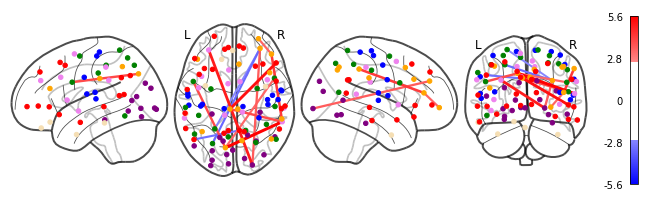

In [31]:
edge_threshold = feature_selec_functions.Pmaxelements(relevant_coefs, 0.05)

plotting.plot_connectome(relF_mat, coordinates, display_mode= 'lzry', 
                         edge_threshold=abs(edge_threshold), node_size=20, node_color = node_colors, colorbar=True)